# Stock Market Data

## Intro

One of the main ways to track the financial aspect of the clean energy sector is the stock market.

For this we will take a look at the The WilderHill New Energy Global Innovation Index (NEX), which according to its creators "*... captures solutions to climate change worldwide, and is comprised of companies mostly outside the U.S. whose innovative technologies and services focus on generation and use of clean energy, lower CO2-renewables, conservation and efficiency. These are companies relevant to solving climate change, whose technologies help reduce emissions relative to traditional fossil fuel use. Since 2006, it has been the first and best-known Index for this theme.*"

It has been used in numerous research papers regarding finance in the renewable energy sector (Zhao, 2020; Kanamura 2020; Inchauspe et al. 2014), meaning it is regarded as a legitimate indicator for movements in the clean energy stock market.

Since our research is focused on only four countries- China, India, Germany, and the US, we will use a subset of the NEX index, which tracks only companies which are listed on the stock markets in said countries. 

As any stock index, companies occasionally get added or removed from the index, thus we will take only the latest version of the company list, filter out companies in the countries of interest, and track their prices from 2000 until 2020, disregarding:

* when these companies got added to the NEX,
* the original timeframe of the NEX, which spans from 2006 until now,
* having a disproportionate number of companies per country.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

In [2]:
nex_companies = pd.read_csv('./Data/NEX_companies.csv', index_col=0)
nex_companies.sample(5)

,company name,description,sec.,cur.,country,symbol
31,Verbio Vereinigte BioEn.,"Biofuels, manufacturer supplier to Germany, Eu...",RBB,EUR,GERMANY,VBK.DE
3,Bloom Energy,"Stationary fuel cells, distributed but non-ren...",ECV,USD,US,BE
28,TPI Composites,Wind Blades; also light-weighting for transpor...,RWD,USD,US,TPIC
4,BYD Co.,"Batteries, potential use in EVs, rail, solar f...",ENS,HKD,CHINA,BYDDF
18,Nordex SE,"Wind turbines, based in Germany/Europe, worldw...",RWD,EUR,GERMANY,NDX1.DE


## Companies distribution

### Country

In [3]:
nex_companies.groupby('country')['country'].count().sort_values(ascending=False)

country
US         22
CHINA       8
GERMANY     5
INDIA       1
Name: country, dtype: int64

### Sector

The companies listed in the NEX are divided into 7 sectors:

* ECV: Energy Conversion
* EEF: Energy Efficiency
* ENS: Energy Storage
* RBB: Renewables - Biofuels & Biomass
* ROH: Renewables - Other
* RSR: Renewable - Solar
* RWD: Renewable - Wind

In [4]:
nex_companies.groupby('sec.')['sec.'].count().sort_values(ascending=False)

sec.
RSR    13
EEF     7
RWD     5
ENS     4
RBB     3
ECV     3
ROH     1
Name: sec., dtype: int64

## The full NEX index

Text(0, 0.5, 'Close')

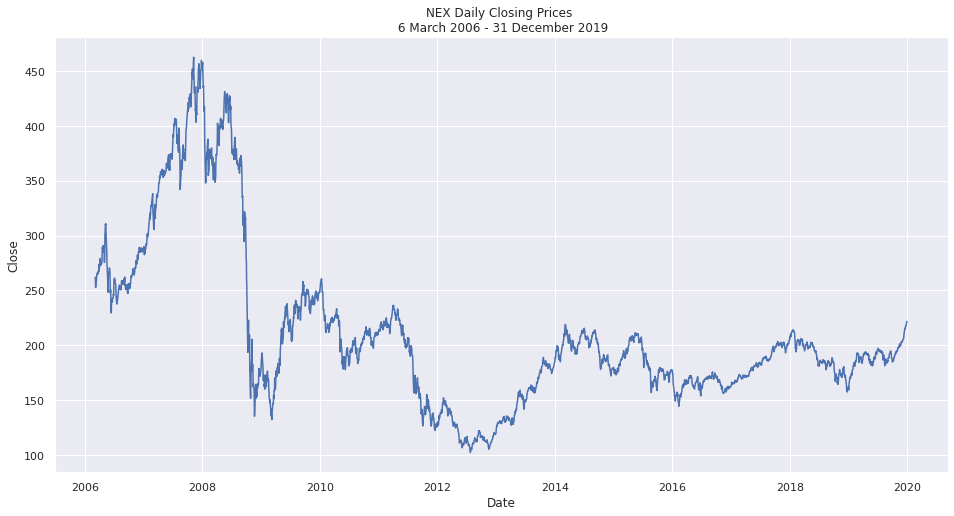

In [5]:
nex_full = pd.read_excel('./Data/NEX_full_prices.xlsx')

plt.figure(figsize=(16, 8))
l = sns.lineplot(data=nex_full, x='Date', y='Close')
l.set_title('NEX Daily Closing Prices \n 6 March 2006 - 31 December 2019')
l.set_ylabel('Close', rotation=90)

Text(0.5, 1.0, 'NEX 200 Day Exponential Moving Average \n 6 March 2006 - 31 December 2019')

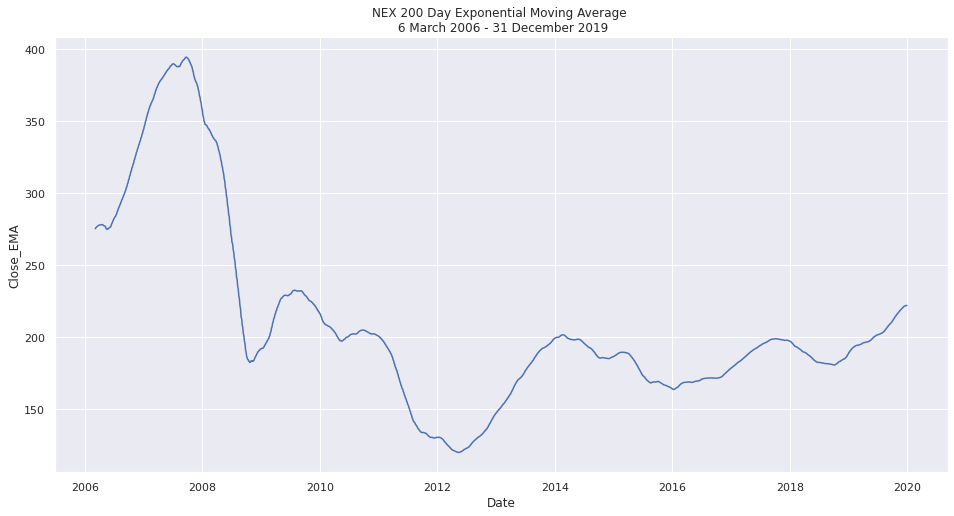

In [6]:
# Calculate 200 day exponential moving average
nex_full['Close_EMA'] = nex_full['Close'].ewm(span=200, adjust=False).mean()
plt.figure(figsize=(16, 8))
sns.lineplot(data=nex_full, x='Date', y='Close_EMA').set_title('NEX 200 Day Exponential Moving Average \n 6 March 2006 - 31 December 2019')

## Subset of the NEX index

The full NEX index is an equal-weight index with a component weight of $\frac{102 stocks}{100}=$ 0.98039216 as of Q1 2021. We, on the other hand, are using a subset of the NEX index, consisting of just 36 companies out of the current 102. Moreover, not all companies have been listed on the stock markets for the entire duration of our the dataset (some companies go public after others also, not all companies have been publicly traded prior to 2000). This poses the question of how we would weigth our sub-index. Ideally, we would weigth the components of our subset of the NEX in such a way that best reflects the price trends of the full NEX.

In [7]:
nex_subset = pd.read_csv('./Data/NEX_subset_prices.csv', index_col='Date')
nex_subset = nex_subset.fillna(0)
nex_subset = nex_subset.loc['2006-03-06':'2019-12-31']

### Approach 1- Constant Equal Weights
The first and most simple approach is to again use equal weigthing. 

Let *$C$* be the total number of companies in our sub-index. Then *$w_c = \frac{1}{C}$* is the weight of any given company $c$.

In [8]:
# calculate weights
C = nex_subset.shape[1]
w = 1 / C

<AxesSubplot:xlabel='Date'>

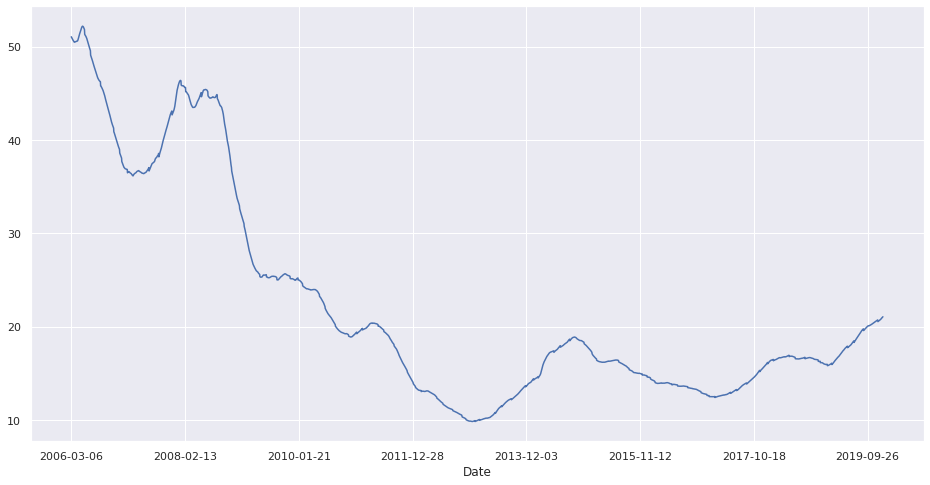

In [9]:
# calculate weighted price data
nex_subset_ceqw = (nex_subset * w).sum(axis=1)
nex_subset_ceqw = nex_subset_ceqw.ewm(span=200, adjust=False).mean()

plt.figure(figsize=(16, 8))
nex_subset_ceqw.plot()

### Approach 2- Dynamic Weights

Another approach would be to apply a dynamic weighting method with which every trading day gets weighted based on the numer of companies being traded on that day.

Let $C$ be the number of companies and
    $
        b_{c, t} = 
            \begin{cases} 
                0 & \text{company $c$ has } \textbf{not } \text{traded on trading day $t$,}\\ 
                1 & \text{company $c$ has traded on trading day $t$}\\
             \end{cases}
    $ denote whether a company $c$ has traded on a day $t$. Then $w_{t} = \frac{1}{\sum_{c=0}^C b_{c, t}}$ is the weight of a given trading day $t$.

In [10]:
C = nex_subset.shape[1]
W = (1 / (nex_subset > 0).astype(int).sum(axis=1))

<AxesSubplot:xlabel='Date'>

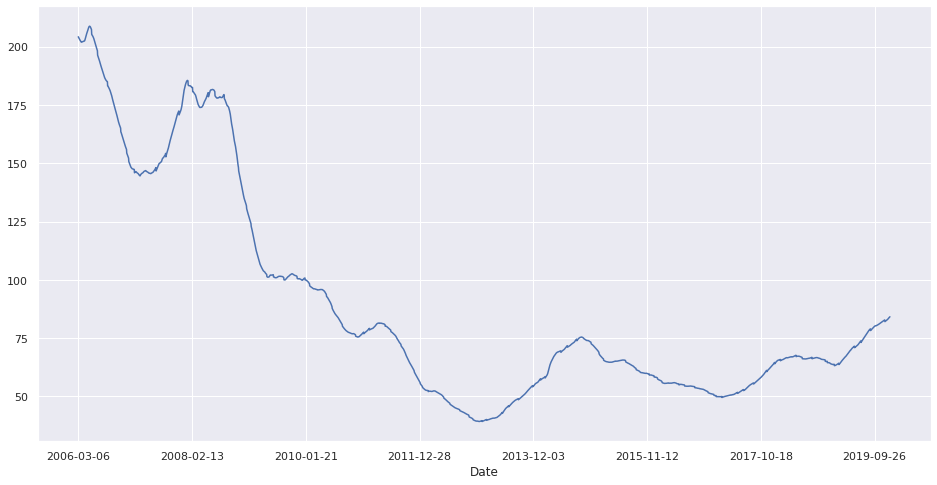

In [11]:
nex_subset_dw = (nex_subset.T * W[0]).T.sum(axis=1)
nex_subset_dw = nex_subset_dw.ewm(span=200, adjust=False).mean()
plt.figure(figsize=(16, 8))
nex_subset_dw.plot()

### Approach 3- Dynamic Equal Weights

A third possible approach is, instead of calculating the trading day weights based on the number of companies traded on the given date, to use the number of companies already listed on the markets.

Let $C_{t'}$ be the number of companies being traded on or before trading day $t$, then $w_{t} = \frac{1}{C_{t'}}$ is the weight of a given trading day $t$.

In [12]:
W = (1 / (nex_subset.cumsum() > 0).astype(int).sum(axis=1))

<AxesSubplot:xlabel='Date'>

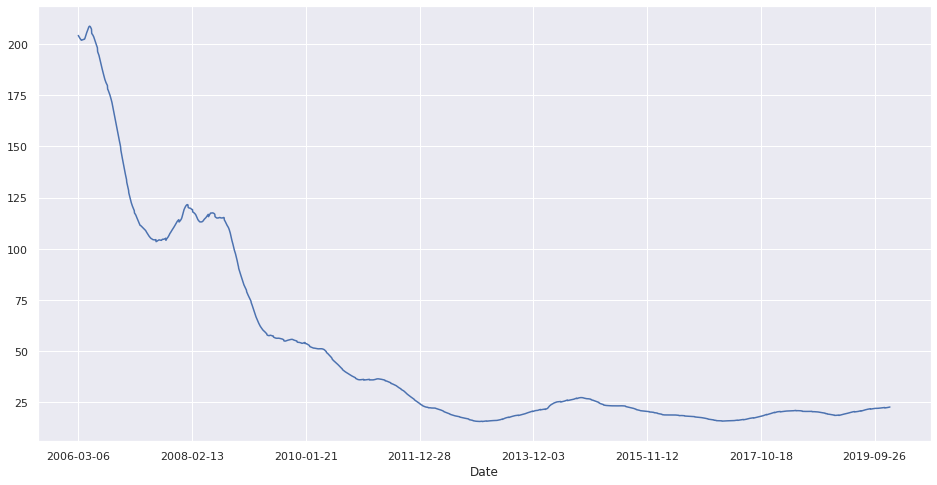

In [13]:
nex_subset_deqw = nex_subset.sum(axis=1) * W
nex_subset_deqw = nex_subset_deqw.ewm(span=200, adjust=False).mean()
plt.figure(figsize=(16,8))
nex_subset_deqw.plot()

### Approach 4- Relative Dynamic Weights

Relative to the number of companies

In [14]:
C = nex_subset.shape[1]
W = (nex_subset > 0).astype(int).sum(axis=1) / C

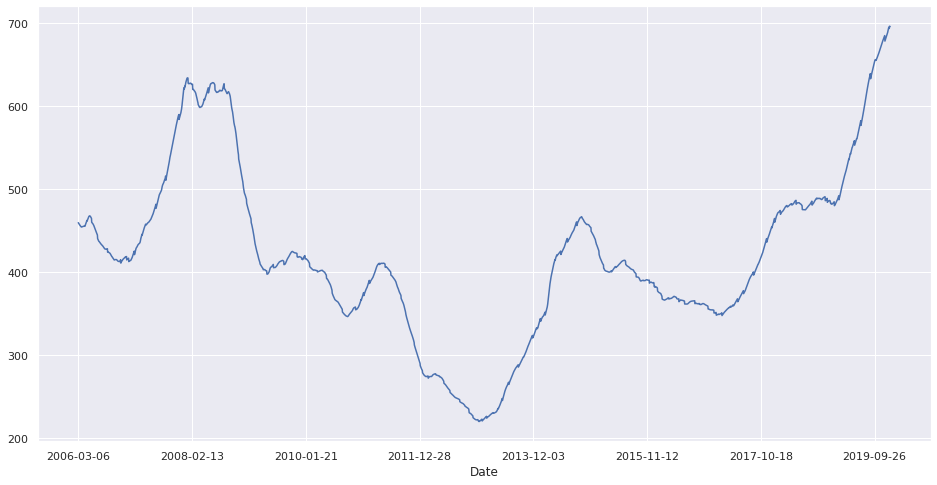

In [61]:
nex_subset_rdw = (nex_subset.T * W).T.sum(axis=1)
nex_subset_rdw = nex_subset_rdw.ewm(span=200, adjust=False).mean()

plt.figure(figsize=(16,8))
h = nex_subset_rdw.plot()

## Deciding on a weigthing method

[Text(0, 0.5, 'Full'),
 Text(0, 1.5, 'Subset Constant Equal Weights'),
 Text(0, 2.5, 'Subset Dynamic Weights'),
 Text(0, 3.5, 'Subset Dynamic Equal Weights'),
 Text(0, 4.5, 'Subset Relative Dynamic Weights')]

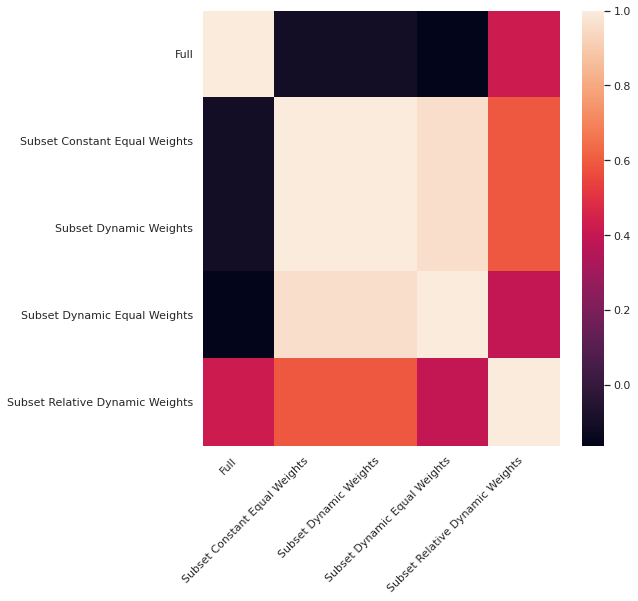

In [102]:
# Find common dates with price data between the full NEX and our subset.
# This is done in order to construct vectors of the same length to be used 
# in our decision analysis.
common_dates = set(nex_full['Date'].astype(str)).intersection(set(nex_subset.index))
common_dates = sorted(list(common_dates))
common_dates = np.array(common_dates)

nex_full = nex_full[nex_full['Date'].isin(pd.to_datetime(common_dates))]

nex_subset_ceqw = nex_subset_ceqw.loc[common_dates]
nex_subset_dw   = nex_subset_dw.loc[common_dates]
nex_subset_deqw = nex_subset_deqw.loc[common_dates]
nex_subset_rdw  = nex_subset_rdw.loc[common_dates]

corr = np.corrcoef(np.array([nex_full['Close_EMA'], nex_subset_ceqw, 
                             nex_subset_dw, nex_subset_deqw, 
                             nex_subset_rdw]))

labels = ['Full', 'Subset Constant Equal Weights', 
          'Subset Dynamic Weights', 'Subset Dynamic Equal Weights',
          'Subset Relative Dynamic Weights']

plt.figure(figsize=(8, 8))
h = sns.heatmap(corr)
h.set_xticklabels(labels=labels, rotation=45, ha='right')
h.set_yticklabels(labels=labels, rotation=0 , va='center')

Seemingly the relative dynmaic weights correlate the most with the full NEX index, although the correlation coefficient is relatively low- 0.37.

Even if we 

In [112]:
import similaritymeasures
import sys

sys.setrecursionlimit(3500)

def distance(full, subset):
    full = full.reset_index(drop=True)
    subset = subset.reset_index().drop('Date', axis=1)
    
    full = np.array([full.index, full['Close_EMA'].values]).T
    subset = np.array([subset.index, subset.values.flatten()]).T
    
    df = similaritymeasures.frechet_dist(full, subset)
    dtw, d = similaritymeasures.dtw(full, subset)
    pcm = similaritymeasures.pcm(full, subset)
    area = similaritymeasures.area_between_two_curves(full, subset)
    cl = similaritymeasures.curve_length_measure(full, subset)

    print(df, dtw, pcm, cl, area)


[distance(nex_full, nex_subset_ceqw),
 distance(nex_full, nex_subset_dw),
 distance(nex_full, nex_subset_deqw),
 distance(nex_full, nex_subset_rdw)]

377.3615982301692 660629.3809538449 1078.1061617823611 43.696687405798755 660417.0106038221
326.8020914096071 425801.1065778805 1944.1194202349955 33.98027927641884 425832.8064682316
373.28870838855727 566378.8026691248 2549.386838249199 39.00175426131634 566399.4895441867
438.3536857537007 737626.4077532532 1024.0574637893276 50.14043615019269 738999.6963822402


[None, None, None, None]

In [113]:
distances = [
    [377.3615982301692 , 660629.3809538449, 1078.1061617823611, 43.696687405798755, 660417.0106038221],
    [326.8020914096071 , 425801.1065778805, 1944.1194202349955, 33.98027927641884 , 425832.8064682316],
    [373.28870838855727, 566378.8026691248, 2549.386838249199 , 39.00175426131634 , 566399.4895441867],
    [438.3536857537007 , 737626.4077532532, 1024.0574637893276, 50.14043615019269 , 738999.6963822402]
]

distances

[[377.3615982301692,
  660629.3809538449,
  1078.1061617823611,
  43.696687405798755,
  660417.0106038221],
 [326.8020914096071,
  425801.1065778805,
  1944.1194202349955,
  33.98027927641884,
  425832.8064682316],
 [373.28870838855727,
  566378.8026691248,
  2549.386838249199,
  39.00175426131634,
  566399.4895441867],
 [438.3536857537007,
  737626.4077532532,
  1024.0574637893276,
  50.14043615019269,
  738999.6963822402]]